#Data Collection, Cleaning, Preparation, and Modelling

## 1. Data Collection

> We add 2 more tickers to the 18 selected stocks; 1 representing the market return/benchmark (SPY) and the other representing the risk-free rate (BIL) - (SPDR Bloomberg 1–3 Month T-Bill ETF).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.covariance import LedoitWolf
from sklearn.decomposition import PCA
import os
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os, math, time, copy, random
from typing import Tuple, Dict, List
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# tickers = ['WMT', 'TM', 'SLV', 'SHY', 'PFE', 'HDB', 'DBA', 'UNH', 'PEP', 'BND',
#            'META', 'ITUB', 'AGG', 'USO', 'TCS.NS', 'IEF', 'NESN.SW', 'SPY', 'BIL']
# len(tickers)

# EDA for selected tickers - with cryptocurrencies
# Tickers and period (use same START_DATE / END_DATE as asset selection)
# tickers = ['WMT','TM','SLV','SHY','PFE','HDB','DBA','UNH','PEP','BND',
#            'META','ITUB','BNB-USD','AGG','USO','TCS.NS','IEF','NESN.SW','SPY','BIL']

# Convert to USD if needed (optional) -- PLACEHOLDER: user must supply FX mapping if desired.
# NOTE: For rigorous covariance estimation convert local-currency tickers (e.g., .NS, .SW) to USD by multiplying
# by FX series. This script assumes you accept Yahoo's USD-quoted ADRs where available.

In [ ]:
tickers = ['PFE', 'TM', 'TSLA', 'AGG', 'NOVN.SW', 'BABA', 'NESN.SW', 'WMT', 'BND', 'PG', 'IEF', 'INFY.NS', 'TLT', 'PSA', 'GLD', 'UNH', 'DBA', 'ITUB', 'SHY', 'SPY','BIL']
# --- Cell 0: imports and params ---
plt.style.use('default')
pd.set_option('display.float_format', '{:.4f}'.format)

# Optional: for GARCH
try:
    from arch import arch_model
    HAVE_ARCH = True
except Exception:
    HAVE_ARCH = False
try:
    START_DATE, END_DATE
except NameError:
    START_DATE = "2015-01-01"
    END_DATE   = "2024-12-31"

In [ ]:
# Fetching data
def fetch_adj_close_volume(tickers, start, end):
    raw = yf.download(tickers, start=start, end=end, progress=True, group_by='ticker', auto_adjust=False)
    # Handle multiindex vs single-ticker returns from yfinance
    if isinstance(raw.columns, pd.MultiIndex):
        adj = pd.DataFrame({t: raw[(t, 'Adj Close')] if (t, 'Adj Close') in raw.columns else raw[(t, 'Close')] for t in tickers})
        vol = pd.DataFrame({t: raw[(t, 'Volume')] if (t, 'Volume') in raw.columns else np.nan for t in tickers})
    else:
        # single ticker
        adj = raw['Adj Close'].to_frame()
        adj.columns = [tickers[0]]
        vol = raw['Volume'].to_frame()
        vol.columns = [tickers[0]]
    adj = adj.dropna(axis=1, how='all')         # drop tickers completely missing
    vol = vol.reindex(adj.index).fillna(method='ffill')   # align
    return adj, vol

prices, volumes = fetch_adj_close_volume(tickers, START_DATE, END_DATE)
print("Downloaded tickers:", prices.columns.tolist())

[*********************100%***********************]  21 of 21 completed

Downloaded tickers: ['PFE', 'TM', 'TSLA', 'AGG', 'NOVN.SW', 'BABA', 'NESN.SW', 'WMT', 'BND', 'PG', 'IEF', 'INFY.NS', 'TLT', 'PSA', 'GLD', 'UNH', 'DBA', 'ITUB', 'SHY', 'SPY', 'BIL']


In [ ]:
# Use daily log returns for statistical properties; also compute simple returns for finance metrics
prices = prices.sort_index()
log_ret = np.log(prices).diff().dropna(how='all')
ret = prices.pct_change().dropna(how='all')

# Align volumes
volumes = volumes.reindex(prices.index)

In [ ]:
# Basic data quality check
missing_summary = pd.DataFrame({
    'n_obs': prices.count(),
    'first_date': prices.apply(lambda s: s.first_valid_index()),
    'last_date': prices.apply(lambda s: s.last_valid_index()),
    'prop_missing': prices.isna().mean()
})
print("\nData quality (per ticker):")
print(missing_summary.T)


Data quality (per ticker):
                              PFE                   TM                 TSLA  \
n_obs                        2515                 2515                 2515   
first_date    2015-01-02 00:00:00  2015-01-02 00:00:00  2015-01-02 00:00:00   
last_date     2024-12-30 00:00:00  2024-12-30 00:00:00  2024-12-30 00:00:00   
prop_missing               0.0301               0.0301               0.0301   

                              AGG              NOVN.SW                 BABA  \
n_obs                        2515                 2515                 2515   
first_date    2015-01-02 00:00:00  2015-01-05 00:00:00  2015-01-02 00:00:00   
last_date     2024-12-30 00:00:00  2024-12-30 00:00:00  2024-12-30 00:00:00   
prop_missing               0.0301               0.0301               0.0301   

                          NESN.SW                  WMT                  BND  \
n_obs                        2515                 2515                 2515   
first_date    2015-01-

In [ ]:
# Drop assets with too many missing values (threshold adjustable)
missing_thresh = 0.25
drop_tks = missing_summary[missing_summary['prop_missing'] > missing_thresh].index.tolist()
if drop_tks:
    print(f"\nDropping {len(drop_tks)} tickers due to >{missing_thresh*100:.0f}% missing: {drop_tks}")
    prices = prices.drop(columns=drop_tks)
    ret    = ret.drop(columns=drop_tks)
    log_ret = log_ret.drop(columns=drop_tks)
    volumes = volumes.drop(columns=drop_tks)

In [ ]:
prices.head()

,PFE,TM,TSLA,AGG,NOVN.SW,BABA,NESN.SW,WMT,BND,PG,...,INFY.NS,TLT,PSA,GLD,UNH,DBA,ITUB,SHY,SPY,BIL
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,373.4010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,19.0180,93.2691,14.6207,82.7847,NaN,98.3884,NaN,23.2666,60.9813,66.9835,...,380.7389,95.8138,123.3866,114.0800,85.0485,21.9442,3.1278,70.3492,171.0937,75.5443
2015-01-05,18.9148,91.5621,14.0060,82.9647,50.3041,95.9192,52.3725,23.1989,61.1584,66.6650,...,377.4670,97.3189,123.9665,115.8000,83.6476,22.2114,3.0905,70.3492,168.0038,75.5608
2015-01-06,19.0726,90.6196,14.0853,83.1746,49.9260,98.1225,52.0078,23.3776,61.3355,66.3613,...,369.5807,99.0724,126.0819,117.1200,83.4788,22.3628,3.1900,70.3824,166.4214,75.5443
2015-01-07,19.3337,92.8980,14.0633,83.1595,50.1690,96.9923,52.1902,23.9979,61.3724,66.7094,...,371.3491,98.8767,128.6653,116.4300,84.3312,22.2559,3.2796,70.4157,168.4952,75.5443


In [ ]:
ret.head()

,PFE,TM,TSLA,AGG,NOVN.SW,BABA,NESN.SW,WMT,BND,PG,...,INFY.NS,TLT,PSA,GLD,UNH,DBA,ITUB,SHY,SPY,BIL
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.0054,-0.0183,-0.0420,0.0022,NaN,-0.0251,NaN,-0.0029,0.0029,-0.0048,...,-0.0086,0.0157,0.0047,0.0151,-0.0165,0.0122,-0.0119,0.0000,-0.0181,0.0002
2015-01-06,0.0083,-0.0103,0.0057,0.0025,-0.0075,0.0230,-0.0070,0.0077,0.0029,-0.0046,...,-0.0209,0.0180,0.0171,0.0114,-0.0020,0.0068,0.0322,0.0005,-0.0094,-0.0002
2015-01-07,0.0137,0.0251,-0.0016,-0.0002,0.0049,-0.0115,0.0035,0.0265,0.0006,0.0052,...,0.0048,-0.0020,0.0205,-0.0059,0.0102,-0.0048,0.0281,0.0005,0.0125,0.0000
2015-01-08,0.0204,0.0193,-0.0016,-0.0015,0.0420,0.0284,0.0182,0.0211,-0.0016,0.0114,...,0.0050,-0.0132,0.0136,-0.0042,0.0477,-0.0036,0.0228,-0.0001,0.0177,0.0000


In [ ]:
log_ret.head()

,PFE,TM,TSLA,AGG,NOVN.SW,BABA,NESN.SW,WMT,BND,PG,...,INFY.NS,TLT,PSA,GLD,UNH,DBA,ITUB,SHY,SPY,BIL
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.0054,-0.0185,-0.0430,0.0022,NaN,-0.0254,NaN,-0.0029,0.0029,-0.0048,...,-0.0086,0.0156,0.0047,0.0150,-0.0166,0.0121,-0.0120,0.0000,-0.0182,0.0002
2015-01-06,0.0083,-0.0103,0.0056,0.0025,-0.0075,0.0227,-0.0070,0.0077,0.0029,-0.0046,...,-0.0211,0.0179,0.0169,0.0113,-0.0020,0.0068,0.0317,0.0005,-0.0095,-0.0002
2015-01-07,0.0136,0.0248,-0.0016,-0.0002,0.0049,-0.0116,0.0035,0.0262,0.0006,0.0052,...,0.0048,-0.0020,0.0203,-0.0059,0.0102,-0.0048,0.0277,0.0005,0.0124,0.0000
2015-01-08,0.0202,0.0191,-0.0016,-0.0015,0.0411,0.0280,0.0180,0.0209,-0.0016,0.0114,...,0.0050,-0.0133,0.0135,-0.0042,0.0466,-0.0036,0.0225,-0.0001,0.0176,0.0000


In [ ]:
volumes.head()

,PFE,TM,TSLA,AGG,NOVN.SW,BABA,NESN.SW,WMT,BND,PG,...,INFY.NS,TLT,PSA,GLD,UNH,DBA,ITUB,SHY,SPY,BIL
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002764.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,16371571.0000,250000.0000,71466000.0000,2090200.0000,NaN,12303400.0000,NaN,13505400.0000,2218800.0000,7251400.0000,...,6778320.0000,9432000.0000,415300.0000,7109600.0000,3060900.0000,261800.0000,16101145.0000,1735400.0000,121465900.0000,341000.0000
2015-01-05,24786391.0000,240600.0000,80527500.0000,3446200.0000,8993542.0000,18337000.0000,7893813.0000,20937000.0000,5820100.0000,8626100.0000,...,9937024.0000,9789500.0000,481900.0000,8177400.0000,4679000.0000,510200.0000,17127969.0000,1214300.0000,169632600.0000,2518350.0000
2015-01-06,29468681.0000,285600.0000,93928500.0000,3688100.0000,6891439.0000,15720400.0000,6594173.0000,24615300.0000,3887600.0000,7791200.0000,...,9667316.0000,18331300.0000,642800.0000,11238300.0000,3468300.0000,345500.0000,31869849.0000,959400.0000,209151400.0000,541250.0000
2015-01-07,20248816.0000,385700.0000,44526000.0000,3984400.0000,6231171.0000,11052200.0000,6512266.0000,25495200.0000,2433400.0000,5986600.0000,...,7249916.0000,9762900.0000,734100.0000,6434200.0000,3225800.0000,223300.0000,18491417.0000,768800.0000,125346700.0000,153800.0000


## 2. EDA

In [ ]:
# descriptive statistics (table)
def descriptive_stats(returns_df):
    out = pd.DataFrame(index=returns_df.columns)
    out['mean_daily'] = returns_df.mean()
    out['std_daily']  = returns_df.std()
    out['skew']       = returns_df.skew()
    out['kurtosis']   = returns_df.kurtosis()
    out['median']     = returns_df.median()
    out['min']        = returns_df.min()
    out['max']        = returns_df.max()
    out['n_obs']      = returns_df.count()
    # annualize mean & std for interpretation (252 trading days)
    out['mean_ann']   = out['mean_daily'] * 252
    out['std_ann']    = out['std_daily'] * np.sqrt(252)
    out['sharpe_ann'] = out['mean_ann'] / out['std_ann']
    # Jarque-Bera normality
    jb = returns_df.apply(lambda x: stats.jarque_bera(x.dropna())[1])
    out['jb_pvalue'] = jb
    return out

stats_table = descriptive_stats(ret)
stats_table

,mean_daily,std_daily,skew,kurtosis,median,min,max,n_obs,mean_ann,std_ann,sharpe_ann,jb_pvalue
PFE,0.0002,0.0144,0.3053,5.1568,0.0000,-0.0773,0.1086,2591,0.0530,0.2289,0.2316,0.0000
TM,0.0004,0.0139,0.1488,4.4042,0.0001,-0.0862,0.0958,2591,0.0943,0.2200,0.4288,0.0000
TSLA,0.0019,0.0355,0.2837,4.6233,0.0003,-0.2106,0.2192,2591,0.4840,0.5631,0.8595,0.0000
AGG,0.0001,0.0033,-1.0970,20.5888,0.0001,-0.0400,0.0237,2591,0.0140,0.0523,0.2667,0.0000
NOVN.SW,0.0003,0.0117,-0.3021,5.6744,0.0000,-0.0979,0.0771,2590,0.0691,0.1858,0.3718,0.0000
BABA,0.0003,0.0258,1.4070,18.9176,0.0000,-0.1334,0.3676,2591,0.0657,0.4102,0.1601,0.0000
NESN.SW,0.0002,0.0101,-0.4357,4.3937,0.0000,-0.0683,0.0591,2590,0.0442,0.1599,0.2763,0.0000
WMT,0.0006,0.0131,0.1609,16.2917,0.0004,-0.1138,0.1171,2591,0.1531,0.2081,0.7357,0.0000
BND,0.0001,0.0034,-0.9672,39.0903,0.0001,-0.0544,0.0422,2591,0.0148,0.0537,0.2761,0.0000
PG,0.0004,0.0115,0.2252,12.8952,0.0003,-0.0874,0.1201,2591,0.1036,0.1820,0.5693,0.0000


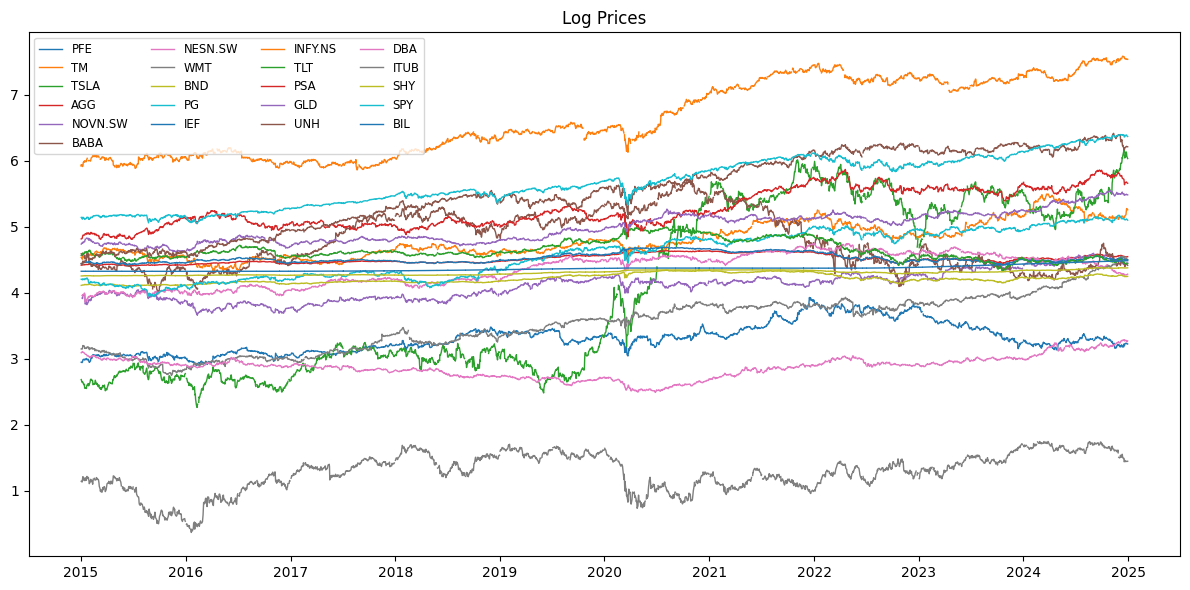

In [ ]:
# time-series plots (prices and cumulative returns)
plt.figure(figsize=(12,6))
for col in prices.columns:
    plt.plot(np.log(prices[col]), label=col, linewidth=1)
plt.title("Log Prices")
plt.legend(loc='best', ncol=4, fontsize='small')
plt.tight_layout()
plt.show()

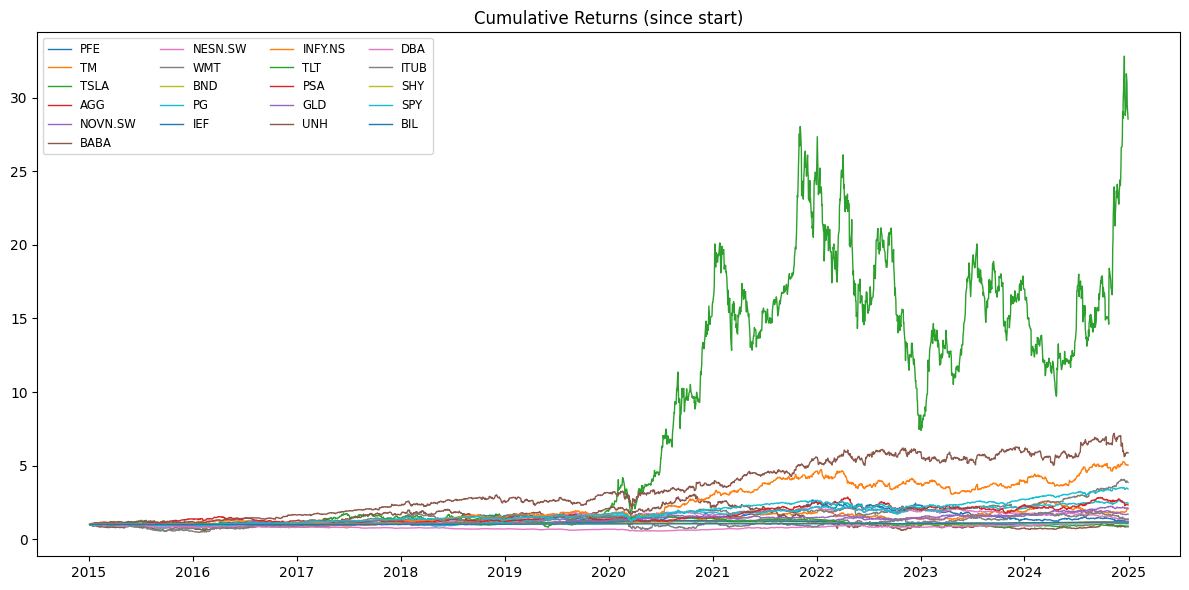

In [ ]:
# cumulative returns (start at 1)
cumret = (1 + ret).cumprod()
plt.figure(figsize=(12,6))
for col in cumret.columns:
    plt.plot(cumret[col], label=col, linewidth=1)
plt.title("Cumulative Returns (since start)")
plt.legend(loc='best', ncol=4, fontsize='small')
plt.tight_layout()
plt.show()

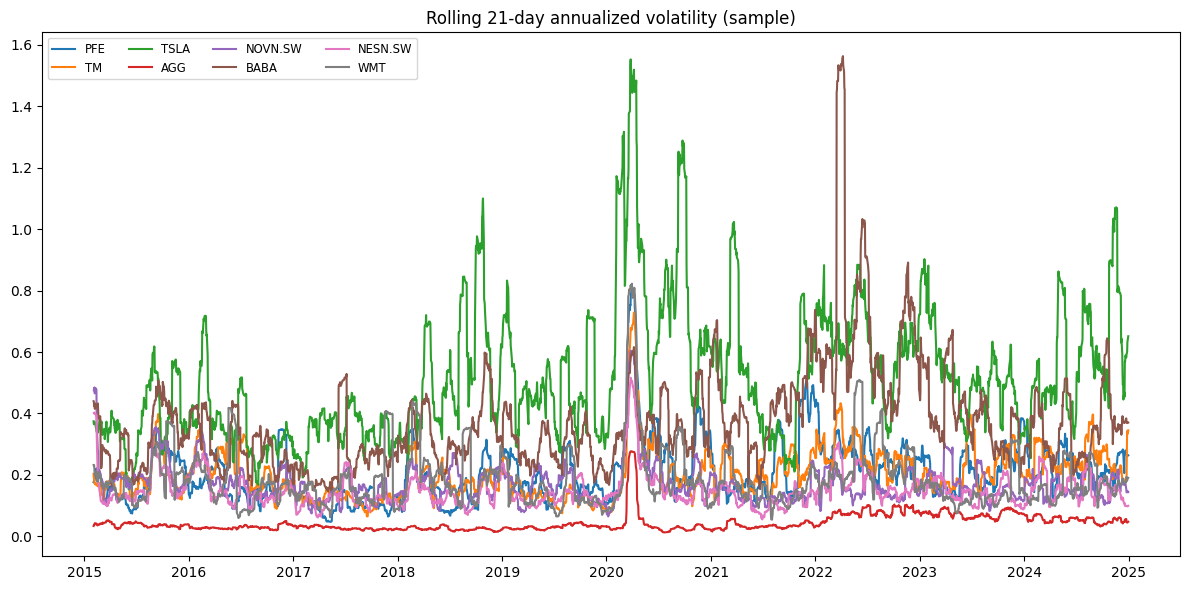

In [ ]:
# rolling statistics (volatility, mean)
window = 21  # 1-month approx
rolling_vol = ret.rolling(window).std() * np.sqrt(252)  # annualized rolling vol
rolling_mean = ret.rolling(window).mean() * 252

# Save rolling vol plots for a sample of assets (top 8)
sample_assets = ret.columns[:8].tolist()
plt.figure(figsize=(12,6))
for col in sample_assets:
    plt.plot(rolling_vol[col], label=col)
plt.title(f"Rolling {window}-day annualized volatility (sample)")
plt.legend(loc='best', fontsize='small', ncol=4)
plt.tight_layout()
plt.show()

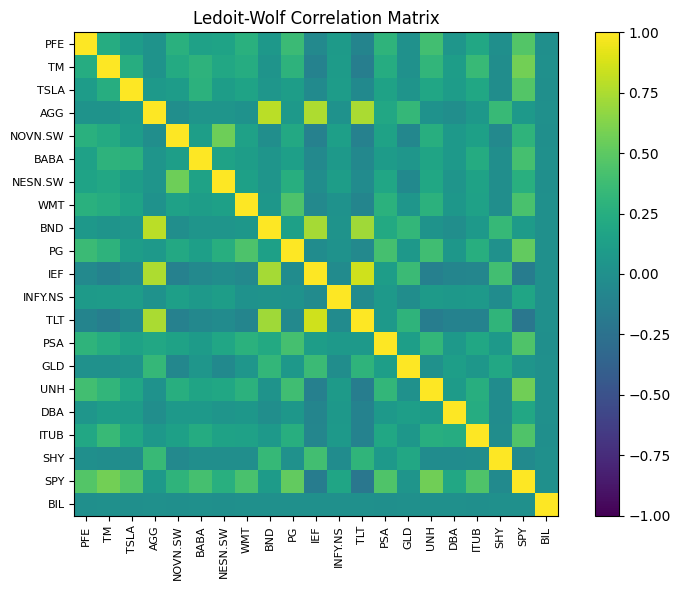

In [ ]:
# correlation and dependence
# 1) sample correlation (full)
corr_sample = ret.corr()


# 2) Ledoit-Wolf shrinkage correlation (more stable for MPT inputs)
lw = LedoitWolf().fit(ret.fillna(0).values)   # caution: fillna used to create matrix; better to drop columns with too many nans earlier
cov_lw = pd.DataFrame(lw.covariance_, index=ret.columns, columns=ret.columns)
corr_lw = cov_lw.divide(np.sqrt(np.diag(cov_lw)) , axis=0).divide(np.sqrt(np.diag(cov_lw)), axis=1)


# Heatmap (requires seaborn if you want fancier; we'll use matplotlib pcolormesh)
plt.figure(figsize=(8,6))
plt.title("Ledoit-Wolf Correlation Matrix")
plt.imshow(corr_lw, interpolation='nearest', vmin=-1, vmax=1)
plt.xticks(range(len(corr_lw)), corr_lw.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr_lw)), corr_lw.index, fontsize=8)
plt.colorbar()
plt.tight_layout()
plt.show()



In [ ]:
corr_lw

,PFE,TM,TSLA,AGG,NOVN.SW,BABA,NESN.SW,WMT,BND,PG,...,INFY.NS,TLT,PSA,GLD,UNH,DBA,ITUB,SHY,SPY,BIL
PFE,1.0000,0.2362,0.1063,0.0288,0.2687,0.1408,0.1623,0.2672,0.0627,0.3603,...,0.0881,-0.0973,0.2977,0.0100,0.3913,0.0476,0.2027,-0.0072,0.4620,-0.0018
TM,0.2362,1.0000,0.2496,0.0305,0.2245,0.2963,0.2006,0.2369,0.0381,0.2922,...,0.0964,-0.1451,0.2419,0.0128,0.3155,0.1115,0.3514,-0.0194,0.5731,0.0022
TSLA,0.1063,0.2496,1.0000,0.0814,0.1036,0.2866,0.1140,0.1572,0.0510,0.1154,...,0.1049,-0.0483,0.1561,0.0351,0.1872,0.1060,0.1903,-0.0231,0.4610,-0.0030
AGG,0.0288,0.0305,0.0814,1.0000,-0.0097,0.0433,0.0446,0.0195,0.7918,0.0849,...,0.0185,0.7451,0.1989,0.3342,0.0194,-0.0124,0.0644,0.3503,0.0845,0.0015
NOVN.SW,0.2687,0.2245,0.1036,-0.0097,1.0000,0.1246,0.5614,0.1473,-0.0129,0.2046,...,0.1315,-0.1247,0.1505,-0.0720,0.2533,0.0828,0.1404,-0.0558,0.3015,-0.0038
BABA,0.1408,0.2963,0.2866,0.0433,0.1246,1.0000,0.1488,0.1134,0.0404,0.1274,...,0.0789,-0.0630,0.0987,0.0504,0.1652,0.0788,0.2291,-0.0155,0.4064,0.0019
NESN.SW,0.1623,0.2006,0.1140,0.0446,0.5614,0.1488,1.0000,0.1361,0.0420,0.2540,...,0.1139,-0.0337,0.1852,-0.0481,0.1951,0.0461,0.1507,-0.0089,0.2604,-0.0031
WMT,0.2672,0.2369,0.1572,0.0195,0.1473,0.1134,0.1361,1.0000,0.0597,0.4430,...,0.0233,-0.0883,0.2764,0.0543,0.2873,0.0594,0.1430,-0.0122,0.4236,0.0033
BND,0.0627,0.0381,0.0510,0.7918,-0.0129,0.0404,0.0420,0.0597,1.0000,0.1389,...,0.0256,0.7158,0.2129,0.3267,0.0282,-0.0139,0.0731,0.3432,0.0978,0.0024
PG,0.3603,0.2922,0.1154,0.0849,0.2046,0.1274,0.2540,0.4430,0.1389,1.0000,...,0.0198,-0.0595,0.4085,0.0657,0.3871,0.0612,0.2566,0.0139,0.5209,0.0007


In [ ]:
# 3) PCA on returns to examine common factors
pca = PCA()
valid_ret = ret.dropna(axis=1, how='all').dropna()
pca.fit(valid_ret.fillna(0).values)
explained = pca.explained_variance_ratio_
explained_df = pd.Series(explained, index=[f"PC{i+1}" for i in range(len(explained))])
explained_df

,0
PC1,0.3423
PC2,0.1597
PC3,0.1110
PC4,0.0853
PC5,0.0568
PC6,0.0398
PC7,0.0336
PC8,0.0316
PC9,0.0301
PC10,0.0273


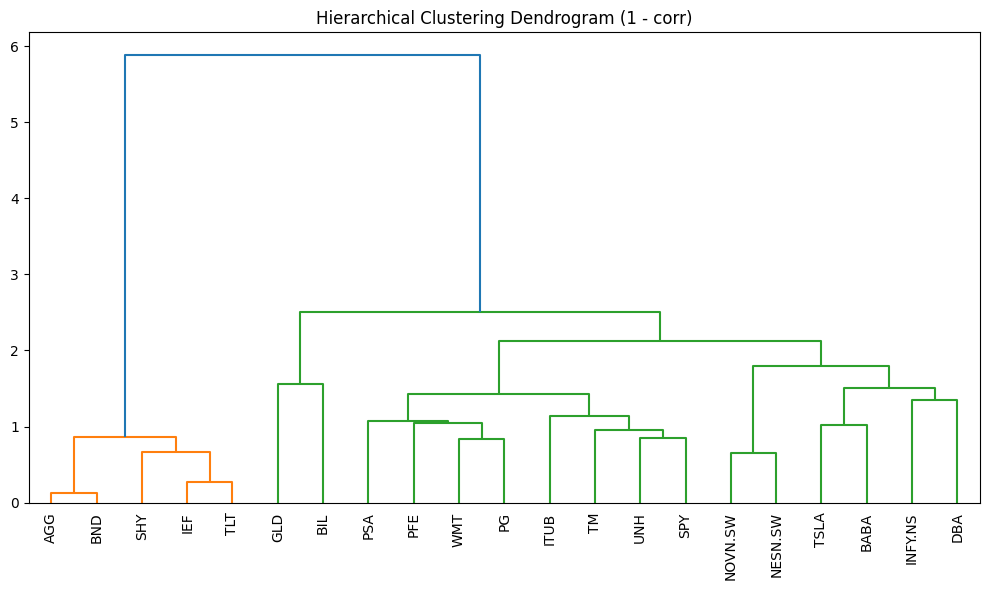

In [ ]:
# hierarchical clustering for asset groups (using corr distance)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# distance = 1 - correlation
dist = 1 - corr_sample.fillna(0)
linked = linkage(dist, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=dist.index.tolist(), leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (1 - corr)")
plt.tight_layout()
plt.show()

In [ ]:
# tail risk and extreme events -
# 1) VaR and CVaR (empirical) at 95% and 99%
def empirical_var_cvar(series, alpha=0.05):
    series = series.dropna()
    var = np.quantile(series, alpha)
    cvar = series[series <= var].mean() if np.any(series <= var) else np.nan
    return var, cvar

var_cvar = {col:{} for col in ret.columns}
for col in ret.columns:
    var95, cvar95 = empirical_var_cvar(ret[col], 0.05)
    var99, cvar99 = empirical_var_cvar(ret[col], 0.01)
    var_cvar[col]['var95'] = var95
    var_cvar[col]['cvar95'] = cvar95
    var_cvar[col]['var99'] = var99
    var_cvar[col]['cvar99'] = cvar99
varcvar_df = pd.DataFrame(var_cvar).T
varcvar_df

,var95,cvar95,var99,cvar99
PFE,-0.0212,-0.0319,-0.0381,-0.0522
TM,-0.0217,-0.0310,-0.0343,-0.0471
TSLA,-0.0509,-0.0784,-0.0899,-0.1240
AGG,-0.0048,-0.0076,-0.0089,-0.0135
NOVN.SW,-0.0176,-0.0271,-0.0315,-0.0438
BABA,-0.0374,-0.0549,-0.0630,-0.0841
NESN.SW,-0.0156,-0.0235,-0.0271,-0.0396
WMT,-0.0179,-0.0290,-0.0315,-0.0544
BND,-0.0048,-0.0076,-0.0087,-0.0134
PG,-0.0159,-0.0269,-0.0332,-0.0475


In [ ]:
# 2) drawdown (max drawdown and top drawdown episodes)
def max_drawdown(series):
    wealth = (1 + series).cumprod()
    peak = wealth.cummax()
    drawdown = (wealth - peak) / peak
    mdd = drawdown.min()
    return mdd, drawdown

mdds = {}
for col in ret.columns:
    mdd, drawdown = max_drawdown(ret[col])
    mdds[col] = mdd
mdd_series = pd.Series(mdds).sort_values()
mdd_series

,0
BABA,-0.8009
TSLA,-0.7363
ITUB,-0.6213
PFE,-0.5482
TLT,-0.4835
DBA,-0.4620
NESN.SW,-0.3809
PSA,-0.3793
TM,-0.3680
INFY.NS,-0.3655


In [ ]:
# autocorrelation / volatility clustering tests ---
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

acf_pvals = {}
arch_pvals = {}
for col in ret.columns:
    ser = ret[col].dropna()
    if len(ser) < 60:  # small-sample guard
        acf_pvals[col] = np.nan
        arch_pvals[col] = np.nan
        continue
    lb = acorr_ljungbox(ser, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
    archp = het_arch(ser, nlags=5)[1]  # returns LM test and p-value
    acf_pvals[col] = lb
    arch_pvals[col] = archp
diag_df = pd.DataFrame({'ljungbox_p10': pd.Series(acf_pvals), 'arch_lm_p': pd.Series(arch_pvals)})
diag_df

,ljungbox_p10,arch_lm_p
PFE,0.0000,0.0000
TM,0.2161,0.0000
TSLA,0.0837,0.0000
AGG,0.0000,0.0000
NOVN.SW,0.0638,0.0000
BABA,0.0124,0.0000
NESN.SW,0.0291,0.0000
WMT,0.0001,0.0000
BND,0.0000,0.0000
PG,0.0000,0.0000


In [ ]:
# fit GARCH(1,1) for a representative asset to quantify conditional volatility dynamics
if HAVE_ARCH:
    sample = ret.columns[0]
    am = arch_model(ret[sample].dropna()*100, vol='Garch', p=1, q=1, dist='t')
    res = am.fit(disp='off')
    print(res.summary())

In [ ]:
#  liquidity metrics
liquidity = pd.DataFrame(index=volumes.columns)
liquidity['avg_volume'] = volumes.mean()
liquidity['median_volume'] = volumes.median()
liquidity['prop_zero_volume'] = (volumes == 0).mean()

In [ ]:
# -beta estimates vs SPY and vs BIL (CAPM and risk-free) ---
betas = {}
for col in ret.columns:
    if col == 'SPY' or col == 'BIL':
        continue
    y = ret[col].dropna()
    x = ret['SPY'].reindex(y.index).dropna()
    idx = y.index.intersection(x.index)
    if len(idx) < 60:
        betas[col] = np.nan
        continue
    X = sm.add_constant(x.loc[idx])
    model = sm.OLS(y.loc[idx], X).fit()
    betas[col] = model.params[1]
beta_series = pd.Series(betas).sort_values()
beta_series

,0
TLT,-0.1827
IEF,-0.0641
SHY,-0.0066
AGG,0.0283
BND,0.0335
GLD,0.0376
DBA,0.1509
NESN.SW,0.2451
INFY.NS,0.2597
NOVN.SW,0.3288


In [ ]:
drop_tks = set(tickers) - set(ret.columns)
summary = {
    'n_assets': len(ret.columns),
    'start_date': ret.index.min().strftime('%Y-%m-%d'),
    'end_date': ret.index.max().strftime('%Y-%m-%d'),
    'n_obs': ret.shape[0],
    'n_missing_tickers': len(drop_tks),
    'missing_tickers': list(drop_tks)
}

print("\nEDA summary:", summary)


EDA summary: {'n_assets': 21, 'start_date': '2015-01-02', 'end_date': '2024-12-30', 'n_obs': 2592, 'n_missing_tickers': 0, 'missing_tickers': []}


In [ ]:
print("Missing tickers:", drop_tks)


Missing tickers: set()


In [ ]:
# <!-- >    TCS.NS was dropped because it contained missing or invalid return values (NaN or inf) after aligning all tickers to the common sample period used for analysis -->